In [1]:
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
ago_18 = pd.read_csv("data/2018_08_Agost_BICING_US.csv")
set_18 = pd.read_csv("data/2018_09_Setembre_BICING_US.csv", sep=';') # all the columns are joined into one here for some reason
oct_18 = pd.read_csv("data/2018_10_Octubre_BICING_US.csv")
nov_18 = pd.read_csv("data/2018_11_Novembre_BICING_US.csv")
des_18 = pd.read_csv("data/2018_12_Desembre_BICING_US.csv")

In [3]:
frames = [ago_18, set_18, oct_18, nov_18, des_18]
df = pd.concat(frames, ignore_index=True)

In [4]:
df['dateTime'] = pd.to_datetime(df['dateTime'])

In [5]:
bank_holidays = ['2018-08-15', 
                 '2018-09-11', 
                 '2018-09-24', 
                 '2018-10-12', 
                 '2018-11-01', 
                 '2018-12-06', 
                 '2018-12-08', 
                 '2018-12-25', 
                 '2018-12-26',
                 '2019-01-01',
                 '2019-04-19',
                 '2019-04-22',
                 '2019-05-01',
                 '2019-06-10',
                 '2019-06-24',
                 '2019-08-15',
                 '2019-09-11',
                 '2019-09-24',
                 '2019-10-12', 
                 '2019-11-01', 
                 '2019-12-06',  
                 '2019-12-25', 
                 '2019-12-26',
                 
                 '2020-01-01',
                 '2020-01-06',
                 '2020-04-10',
                 '2020-04-13',
                 '2020-05-01',
                 '2020-06-01',
                 '2020-06-24',
                 '2020-08-15',
                 '2020-09-11',
                 '2020-09-24',
                 '2020-10-12', 
                 '2020-11-01', 
                 '2020-12-08',  
                 '2020-12-25', 
                 '2020-12-26',
                 
                 '2021-01-01',
                 '2021-01-06',
                 '2021-04-02',
                 '2021-04-05',
                 '2021-05-01',
                 '2021-05-24',
                 '2021-06-24',
                 '2021-09-11',
                 '2021-09-24',
                 '2021-10-12', 
                 '2021-11-01', 
                 '2021-12-06',  
                 '2021-12-08', 
                 '2021-12-25',
                 
                 '2022-01-01',
                 '2022-01-06',
                 '2022-04-15',
                 '2022-04-18',
                 '2022-06-06',
                 '2022-06-24',
                 '2022-08-15',
                 '2022-09-24',
                 '2022-09-26',
                 '2022-10-12', 
                 '2022-11-01', 
                 '2022-12-06',  
                 '2022-12-08', 
                 '2022-12-26',
                 
                 '2023-01-01',
                 '2023-01-06',
                 '2023-04-07',
                 '2023-04-10',
                 '2023-05-01',
                 '2023-06-05',
                 '2023-06-24',
                 '2023-08-15',
                 '2023-09-11',
                 '2023-09-25',
                 '2023-10-12', 
                 '2023-11-01', 
                 '2023-12-06',
                 '2023-12-08',  
                 '2023-12-25', 
                 '2023-12-26',
                  ]
df['is_weekend'] = df['dateTime'].dt.dayofweek // 5 == 1
df['is_bank_holiday'] = df['dateTime'].dt.strftime('%Y-%m-%d').isin(bank_holidays)

In [6]:
df['is_weekend_or_bank_holiday'] = df['is_weekend'] | df['is_bank_holiday']

In [7]:
eve_of_bank_holidays = ['2018-08-14', '2018-09-10', '2018-09-23', '2018-10-11', '2018-10-31', '2018-12-05', '2018-12-07', '2018-12-24', '2018-12-25']

In [8]:
df['is_eve_of_weekend_or_bank_holiday'] = (
    (df['dateTime'].dt.dayofweek == 4) |
    (df['dateTime'].dt.dayofweek == 5) | 
    (df['dateTime'].dt.strftime('%Y-%m-%d').isin(eve_of_bank_holidays))
)

In [9]:
columns_to_drop = ['is_weekend', 'is_bank_holiday']

In [10]:
df = df.drop(columns=columns_to_drop)

In [11]:
morning_range = (6, 12)
afternoon_range = (12, 18)
evening_range = (18, 24)
night_range = (0, 6)

In [12]:
def categorize_time(hour):
    if morning_range[0] <= hour < morning_range[1]:
        return 'Morning'
    elif afternoon_range[0] <= hour < afternoon_range[1]:
        return 'Afternoon'
    elif evening_range[0] <= hour < evening_range[1]:
        return 'Evening'
    else:
        return 'Night'

In [13]:
df['time_of_day'] = df['dateTime'].dt.hour.apply(categorize_time)

In [14]:
df = df.drop(columns = "error")

In [15]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 41.38879,
	"longitude": 2.15899,
	"start_date": "2018-08-01",
	"end_date": "2018-12-31",
	"hourly": ["temperature_2m", "rain"],
	"timezone": "Europe/Berlin"
}
responses = openmeteo.weather_api(url, params=params)

In [16]:
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

Coordinates 41.37082290649414°E 2.068965435028076°N
Elevation 44.0 m asl
Timezone b'Europe/Berlin' b'CET'
Timezone difference to GMT+0 3600 s


In [17]:
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_rain = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s"),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["rain"] = hourly_rain

hourly_weather_df = pd.DataFrame(data = hourly_data)

In [18]:
hourly_weather_df['date'] = pd.to_datetime(hourly_weather_df['date'])

In [19]:
def get_temperature(row):
    hour_category = row['dateTime'].replace(minute=0, second=0, microsecond=0)
    matching_row = hourly_weather_df[hourly_weather_df['date'] == hour_category]
    
    if not matching_row.empty:
        return matching_row.iloc[0]['temperature_2m']
    else:
        return None

In [20]:
def get_precipitation(row):
    hour_category = row['dateTime'].replace(minute=0, second=0, microsecond=0)
    matching_row = hourly_weather_df[hourly_weather_df['date'] == hour_category]
    
    if not matching_row.empty:
        return matching_row.iloc[0]['rain']
    else:
        return None

In [21]:
df['temperature'] = df.apply(get_temperature, axis=1)

In [22]:
df['precipitation'] = df.apply(get_precipitation, axis=1)

In [23]:
df['date'] = df['dateTime'].dt.date

In [24]:
df['avg_daily_temperature'] = df.groupby('date')['temperature'].transform('mean')

In [25]:
df['avg_bike_use'] = df.groupby('date')['bikesInUsage'].transform('mean')

In [26]:
df['rain_bool'] = df.groupby('date')['precipitation'].transform(lambda x: (x > 0).any())

In [27]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

In [28]:
columns_to_convert = ['is_weekend_or_bank_holiday', 'is_eve_of_weekend_or_bank_holiday', 'rain_bool']

df[columns_to_convert] = df[columns_to_convert].astype(int)

In [29]:
df = df.drop("date", axis=1)

In [30]:
pd.set_option('display.max_rows', 20)

In [32]:
df.to_csv("data/bicing_visualisation.csv", index = True)

In [33]:
df_model = pd.read_csv("data/bicing_visualisation.csv")

In [34]:
df_model[columns_to_convert] = df_model[columns_to_convert].astype(bool)

In [35]:
df_model = df_model.drop("Unnamed: 0", axis=1)

In [36]:
dummy_columns = ['is_weekend_or_bank_holiday', 'is_eve_of_weekend_or_bank_holiday', 'time_of_day', 'rain_bool']

In [37]:
df_model = pd.get_dummies(df_model, columns=dummy_columns, prefix=dummy_columns, drop_first=False, dtype = int)


In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [39]:
corr_bicing = df_model[["bikesInUsage", "temperature", "precipitation", "is_weekend_or_bank_holiday_True", "is_eve_of_weekend_or_bank_holiday_True", "time_of_day_Morning", "time_of_day_Afternoon", "time_of_day_Evening", "time_of_day_Night"]].corr()

In [40]:
sns.set_context("poster")
sns.set(rc={"figure.figsize": (12.,6.)})
sns.set_style("whitegrid")

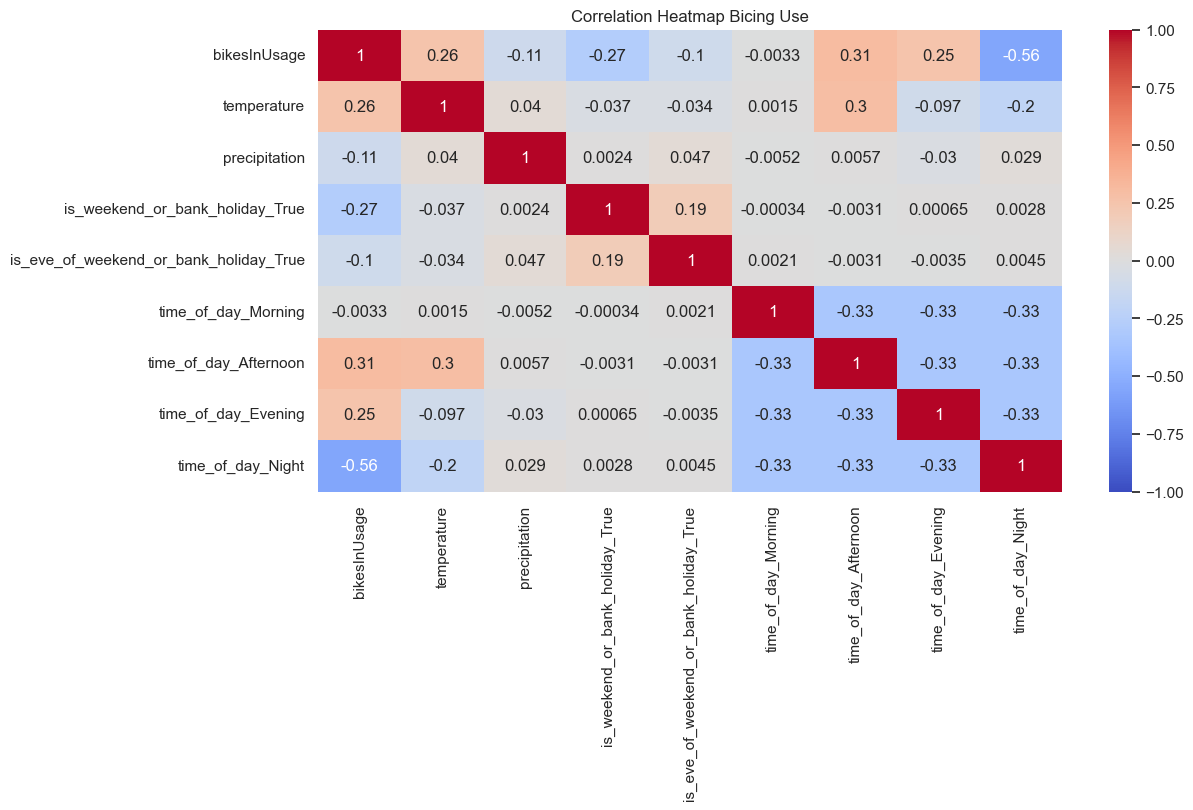

In [41]:
sns.heatmap(corr_bicing, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap Bicing Use')
plt.show()

In [42]:
df_model = df_model.ffill()

In [43]:
df_model.isna().sum()

bikesInUsage                               0
electricalBikesInUsage                     0
mechanicalBikesInUsage                     0
dateTime                                   0
temperature                                0
precipitation                              0
avg_daily_temperature                      0
avg_bike_use                               0
is_weekend_or_bank_holiday_False           0
is_weekend_or_bank_holiday_True            0
is_eve_of_weekend_or_bank_holiday_False    0
is_eve_of_weekend_or_bank_holiday_True     0
time_of_day_Afternoon                      0
time_of_day_Evening                        0
time_of_day_Morning                        0
time_of_day_Night                          0
rain_bool_False                            0
rain_bool_True                             0
dtype: int64

In [44]:
X = df_model[["temperature", "precipitation", "is_weekend_or_bank_holiday_True", "is_eve_of_weekend_or_bank_holiday_True", "time_of_day_Morning", "time_of_day_Afternoon", "time_of_day_Evening", "time_of_day_Night"]]
y = df_model.bikesInUsage

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [46]:
bicing_RFR = RFR()

In [47]:
bicing_RFR.fit(X_train, y_train)

RandomForestRegressor()

In [48]:
y_pred = bicing_RFR.predict(X_train)
print(f"r2: {metrics.r2_score(y_train, y_pred)}")

r2: 0.8814523883959342


In [49]:
np.sqrt(mean_squared_error(y_pred, y_train))

80.94350208097505

In [50]:
y_pred = bicing_RFR.predict(X_test)
print(f"r2: {metrics.r2_score(y_test, y_pred)}")

r2: 0.8421431656625418


In [51]:
np.sqrt(mean_squared_error(y_pred, y_test))

94.07611702834663

In [52]:
df_model['y_pred'] = bicing_RFR.predict(X)

In [53]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 41.38879,
	"longitude": 2.15899,
	"start_date": "2019-01-01",
	"end_date": "2023-11-31",
	"hourly": ["temperature_2m", "rain"],
	"timezone": "Europe/Berlin"
}
responses = openmeteo.weather_api(url, params=params)

In [54]:
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

Coordinates 41.37082290649414°E 2.068965435028076°N
Elevation 44.0 m asl
Timezone b'Europe/Berlin' b'CET'
Timezone difference to GMT+0 3600 s


In [55]:
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_rain = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s"),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["rain"] = hourly_rain

hourly_future_weather_df = pd.DataFrame(data = hourly_data)

In [56]:
hourly_future_weather_df.head(5)

,date,temperature_2m,rain
0,2018-12-31 23:00:00,5.99,0.0
1,2019-01-01 00:00:00,6.79,0.0
2,2019-01-01 01:00:00,6.34,0.0
3,2019-01-01 02:00:00,6.44,0.0
4,2019-01-01 03:00:00,6.19,0.0


In [57]:
new_column_names = {'temperature_2m': 'temperature', 'rain': 'precipitation', 'date': 'dateTime'}
hourly_future_weather_df.rename(columns=new_column_names, inplace=True)

In [58]:
hourly_future_weather_df['dateTime'] = pd.to_datetime(hourly_future_weather_df['dateTime'])

In [59]:
hourly_future_weather_df['bikesInUsage'] = None
hourly_future_weather_df['electricalBikesInUsage'] = None
hourly_future_weather_df['mechanicalBikesInUsage'] = None

In [60]:
hourly_future_weather_df.head(1)

,dateTime,temperature,precipitation,bikesInUsage,electricalBikesInUsage,mechanicalBikesInUsage
0,2018-12-31 23:00:00,5.99,0.0,None,None,None


In [61]:
bank_holidays = ['2018-08-15', 
                 '2018-09-11', 
                 '2018-09-24', 
                 '2018-10-12', 
                 '2018-11-01', 
                 '2018-12-06', 
                 '2018-12-08', 
                 '2018-12-25', 
                 '2018-12-26',
                 '2019-01-01',
                 '2019-04-19',
                 '2019-04-22',
                 '2019-05-01',
                 '2019-06-10',
                 '2019-06-24',
                 '2019-08-15',
                 '2019-09-11',
                 '2019-09-24',
                 '2019-10-12', 
                 '2019-11-01', 
                 '2019-12-06',  
                 '2019-12-25', 
                 '2019-12-26',
                 
                 '2020-01-01',
                 '2020-01-06',
                 '2020-04-10',
                 '2020-04-13',
                 '2020-05-01',
                 '2020-06-01',
                 '2020-06-24',
                 '2020-08-15',
                 '2020-09-11',
                 '2020-09-24',
                 '2020-10-12', 
                 '2020-11-01', 
                 '2020-12-08',  
                 '2020-12-25', 
                 '2020-12-26',
                 
                 '2021-01-01',
                 '2021-01-06',
                 '2021-04-02',
                 '2021-04-05',
                 '2021-05-01',
                 '2021-05-24',
                 '2021-06-24',
                 '2021-09-11',
                 '2021-09-24',
                 '2021-10-12', 
                 '2021-11-01', 
                 '2021-12-06',  
                 '2021-12-08', 
                 '2021-12-25',
                 
                 '2022-01-01',
                 '2022-01-06',
                 '2022-04-15',
                 '2022-04-18',
                 '2022-06-06',
                 '2022-06-24',
                 '2022-08-15',
                 '2022-09-24',
                 '2022-09-26',
                 '2022-10-12', 
                 '2022-11-01', 
                 '2022-12-06',  
                 '2022-12-08', 
                 '2022-12-26',
                 
                 '2023-01-01',
                 '2023-01-06',
                 '2023-04-07',
                 '2023-04-10',
                 '2023-05-01',
                 '2023-06-05',
                 '2023-06-24',
                 '2023-08-15',
                 '2023-09-11',
                 '2023-09-25',
                 '2023-10-12', 
                 '2023-11-01', 
                 '2023-12-06',
                 '2023-12-08',  
                 '2023-12-25', 
                 '2023-12-26',
                  ]
hourly_future_weather_df['is_weekend'] = hourly_future_weather_df['dateTime'].dt.dayofweek // 5 == 1
hourly_future_weather_df['is_bank_holiday'] = hourly_future_weather_df['dateTime'].dt.strftime('%Y-%m-%d').isin(bank_holidays)

In [62]:
hourly_future_weather_df['is_weekend_or_bank_holiday'] = hourly_future_weather_df['is_weekend'] | hourly_future_weather_df['is_bank_holiday']

In [63]:
eve_of_bank_holidays = ['2018-08-14', '2018-09-10', '2018-09-23', '2018-10-11', '2018-10-31', '2018-12-05', '2018-12-07', '2018-12-24', '2018-12-25', '2018-12-31', '2019-04-18', '2019-04-21', '2019-04-30', '2019-06-09', '2019-06-23', '2019-08-14', '2019-09-10', '2019-09-23', '2019-10-11', '2019-10-31', '2019-12-05', '2019-12-24', '2019-12-25', '2019-12-31', '2020-01-05', '2020-01-05', '2020-04-09', '2020-04-12', '2020-04-30', '2020-05-31', '2020-06-23', '2020-08-14', '2020-09-10', '2020-09-23', '2020-10-11', '2020-10-31', '2020-12-07', '2020-12-24', '2020-12-25', '2020-12-31', '2021-01-05', '2021-01-05', '2021-04-01', '2021-04-04', '2021-04-30', '2021-05-23', '2021-06-23', '2021-09-10', '2021-09-23', '2021-10-11', '2021-10-31', '2021-12-05', '2021-12-07', '2021-12-24', '2022-01-05', '2022-01-05', '2022-04-14', '2022-04-17', '2022-06-05', '2022-06-23', '2022-08-14', '2022-09-23', '2022-09-25', '2022-10-11', '2022-10-31', '2022-12-05', '2022-12-07', '2022-12-25', '2022-12-25', '2022-12-31', '2023-01-05', '2023-01-05', '2023-04-06', '2023-04-09', '2023-04-30', '2023-06-04', '2023-06-23', '2023-08-14', '2023-09-10', '2023-09-24', '2023-10-11', '2023-10-31', '2023-12-05', '2023-12-07', '2023-12-24', '2023-12-25', '2023-12-31']

In [64]:
hourly_future_weather_df['is_eve_of_weekend_or_bank_holiday'] = (
    (hourly_future_weather_df['dateTime'].dt.dayofweek == 4) |
    (hourly_future_weather_df['dateTime'].dt.dayofweek == 5) | 
    (hourly_future_weather_df['dateTime'].dt.strftime('%Y-%m-%d').isin(eve_of_bank_holidays))
)

In [65]:
columns_to_drop = ['is_weekend', 'is_bank_holiday']

In [66]:
hourly_future_weather_df = hourly_future_weather_df.drop(columns=columns_to_drop)

In [67]:
morning_range = (6, 12)
afternoon_range = (12, 18)
evening_range = (18, 24)
night_range = (0, 6)

In [68]:
hourly_future_weather_df['time_of_day'] = hourly_future_weather_df['dateTime'].dt.hour.apply(categorize_time)

In [69]:
hourly_future_weather_df['date'] = hourly_future_weather_df['dateTime'].dt.date

In [70]:
hourly_future_weather_df['avg_daily_temperature'] = hourly_future_weather_df.groupby('date')['temperature'].transform('mean')

In [71]:
hourly_future_weather_df['avg_bike_use'] = hourly_future_weather_df.groupby('date')['bikesInUsage'].transform('mean')

In [72]:
hourly_future_weather_df['rain_bool'] = hourly_future_weather_df.groupby('date')['precipitation'].transform(lambda x: (x > 0).any())

In [73]:
hourly_future_weather_df = hourly_future_weather_df.drop("date", axis=1)

In [74]:
column_order = ["bikesInUsage", "electricalBikesInUsage", "mechanicalBikesInUsage", "dateTime", "is_weekend_or_bank_holiday", "is_eve_of_weekend_or_bank_holiday", "time_of_day", "temperature", "precipitation", "avg_daily_temperature", "avg_bike_use", "rain_bool"]
hourly_future_weather_df = hourly_future_weather_df[column_order]

In [75]:
hourly_future_weather_df[columns_to_convert] = hourly_future_weather_df[columns_to_convert].astype(bool)

In [76]:
dummy_columns = ['is_weekend_or_bank_holiday', 'is_eve_of_weekend_or_bank_holiday', 'time_of_day', 'rain_bool']

In [77]:
hourly_future_weather_df = pd.get_dummies(hourly_future_weather_df, columns=dummy_columns, prefix=dummy_columns, drop_first=False, dtype = int)

In [78]:
hourly_future_weather_df.head(1)

,bikesInUsage,electricalBikesInUsage,mechanicalBikesInUsage,dateTime,temperature,precipitation,avg_daily_temperature,avg_bike_use,is_weekend_or_bank_holiday_False,is_weekend_or_bank_holiday_True,is_eve_of_weekend_or_bank_holiday_False,is_eve_of_weekend_or_bank_holiday_True,time_of_day_Afternoon,time_of_day_Evening,time_of_day_Morning,time_of_day_Night,rain_bool_False,rain_bool_True
0,None,None,None,2018-12-31 23:00:00,5.99,0.0,5.99,NaN,1,0,0,1,0,1,0,0,1,0


In [79]:
Z = hourly_future_weather_df[["temperature", "precipitation", "is_weekend_or_bank_holiday_True", "is_eve_of_weekend_or_bank_holiday_True", "time_of_day_Morning", "time_of_day_Afternoon", "time_of_day_Evening", "time_of_day_Night"]]

In [80]:
hourly_future_weather_df['y_pred'] = bicing_RFR.predict(Z)

In [81]:
final_model_df = pd.concat([df_model, hourly_future_weather_df], ignore_index=True)

/var/folders/q9/jkycd7cd6tqdf410bnlz4q2c0000gn/T/ipykernel_14632/1514970495.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_model_df = pd.concat([df_model, hourly_future_weather_df], ignore_index=True)


In [84]:
final_model_df

,bikesInUsage,electricalBikesInUsage,mechanicalBikesInUsage,dateTime,temperature,precipitation,avg_daily_temperature,avg_bike_use,is_weekend_or_bank_holiday_False,is_weekend_or_bank_holiday_True,is_eve_of_weekend_or_bank_holiday_False,is_eve_of_weekend_or_bank_holiday_True,time_of_day_Afternoon,time_of_day_Evening,time_of_day_Morning,time_of_day_Night,rain_bool_False,rain_bool_True,y_pred
0,659,14,645,2018-08-01 17:43:27,30.689999,0.0,27.905384,594.0,1,0,1,0,1,0,0,0,1,0,537.611247
1,666,16,650,2018-08-01 17:45:40,30.689999,0.0,27.905384,594.0,1,0,1,0,1,0,0,0,1,0,537.611247
2,648,11,637,2018-08-01 18:00:42,30.240000,0.0,27.905384,594.0,1,0,1,0,0,1,0,0,1,0,799.796210
3,845,13,832,2018-08-01 18:15:40,30.240000,0.0,27.905384,594.0,1,0,1,0,0,1,0,0,1,0,799.796210
4,889,13,876,2018-08-01 18:30:40,30.240000,0.0,27.905384,594.0,1,0,1,0,0,1,0,0,1,0,799.796210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69067,None,None,None,2023-12-01 18:00:00,13.090000,0.0,14.531304,NaN,1,0,0,1,0,1,0,0,0,1,435.526815
69068,None,None,None,2023-12-01 19:00:00,11.240001,0.0,14.531304,NaN,1,0,0,1,0,1,0,0,0,1,787.129784
69069,None,None,None,2023-12-01 20:00:00,10.640000,0.0,14.531304,NaN,1,0,0,1,0,1,0,0,0,1,510.590016
69070,None,None,None,2023-12-01 21:00:00,10.590000,0.0,14.531304,NaN,1,0,0,1,0,1,0,0,0,1,510.590016


In [283]:
final_model_df.to_csv("data/final_model.csv")